# PyTorch ONNX Tensorflow

Transfer PyTorch model to ONNX format and import ONNX model with Tensorflow.

## Define a PyTorch model and train model

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.classifier(x)
        return x
    
    def load_mnist_data(self, batch_size=10):
        transform = transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        classes = ('0', '1', '2', '3', '4', 
                   '5', '6', '7', '8', '9')

        trainset = torchvision.datasets.MNIST(root='data/MNIST', train=True,
                                              download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                  shuffle=True, num_workers=2)

        testset = torchvision.datasets.MNIST(root='data/MNIST', train=False,
                                             download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)
        return trainloader, testloader, classes


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
net = Net().to(device)
batch_size = 40
trainloader, testloader, classes = net.load_mnist_data(batch_size=batch_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

EPOCHS = 1 # 2
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))

[1,  1000] loss: 0.132


<class 'int'>
counts: 39, batch_size: 40, acc: 0.975


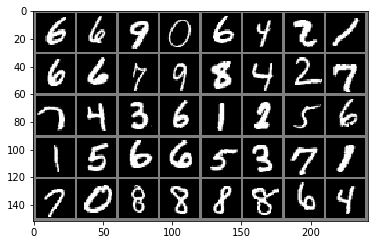

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

images = images.to(device)
labels = labels.to(device)

outputs = net(images)
_, predict = torch.max(outputs, 1)

# accuracy
counts = torch.sum(torch.eq(labels, predict)).cpu().item()
acc = counts / predict.shape[0]
print(type(counts))
print("counts: {}, batch_size: {}, acc: {}".format(
      counts, batch_size ,acc))

## Export PyTorch model

In [4]:
# torch.save(net.state_dict(), "model/pytorch_mnist.pth")

## Export the PyTorch model to ONNX

In [5]:
import os
if not os.path.isdir("model"):
    os.mkdir("model")

# Export dummy input and trained model to ONNX
dummy_input = torch.randn(1, 1, 28, 28)
torch.onnx.export(net.to("cpu"), 
                  dummy_input, 
                  "model/pytorch_mnist.onnx",
                  verbose=True,
                  export_params=True
                 )

graph(%0 : Float(1, 1, 28, 28)
      %1 : Float(6, 1, 5, 5)
      %2 : Float(6)
      %3 : Float(16, 6, 5, 5)
      %4 : Float(16)
      %5 : Float(120, 256)
      %6 : Float(120)
      %7 : Float(84, 120)
      %8 : Float(84)
      %9 : Float(10, 84)
      %10 : Float(10)) {
  %11 : Float(1, 6, 24, 24) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[5, 5], pads=[0, 0, 0, 0], strides=[1, 1]](%0, %1, %2), scope: Net/Sequential[features]/Conv2d[0]
  %12 : Float(1, 6, 12, 12) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%11), scope: Net/Sequential[features]/MaxPool2d[1]
  %13 : Float(1, 16, 8, 8) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[5, 5], pads=[0, 0, 0, 0], strides=[1, 1]](%12, %3, %4), scope: Net/Sequential[features]/Conv2d[2]
  %14 : Float(1, 16, 4, 4) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%13), scope: Net/Sequential[features]/MaxPool2d[3]
  %15 : Dynamic = onnx::Constant[value=  -1  256 [ CPULongType{2

## Import the ONNX model to Tensorflow

In [6]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX file
model = onnx.load("model/pytorch_mnist.onnx")

# Import the ONNX model to Tensorflow
tf_rep = prepare(model)

/usr/local/lib/python3.5/dist-packages/onnx_tf/common/__init__.py:87: UserWarning: FrontendHandler.get_outputs_names is deprecated. It will be removed in future release.. Use node.outputs instead.
  warnings.warn(message)
/usr/local/lib/python3.5/dist-packages/onnx_tf/common/handler_helper.py:73: UserWarning: Unknown op Sinh in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/usr/local/lib/python3.5/dist-packages/onnx_tf/common/handler_helper.py:73: UserWarning: Unknown op Acosh in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/usr/local/lib/python3.5/dist-packages/onnx_tf/common/handler_helper.py:73: UserWarning: Unknown op ConstantLike in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/usr/local/lib/python3.5/dist-packages/onnx_tf/common/handler_helper.py:73: UserWarning: Unknown op Asinh in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/usr/local/lib/python3.5/dist-packages/onnx_tf/common/handler_helper

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [7]:
tf_out = tf_rep.run(dummy_input.numpy())

torch_out = net(dummy_input).detach().cpu().numpy()

np.testing.assert_almost_equal(tf_out[0], 
                               torch_out, 
                               decimal=3
                              )

print("Exported model has been executed on TF backend, and the result looks good!")

Exported model has been executed on TF backend, and the result looks good!


# Save the Tensorflow model into a file

In [8]:
tf_rep.export_graph("model/mnist.pb")